Discard: Overfitting trial

In [1]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
import skimage.filters

In [2]:
from fft_conv_pytorch import fft_conv, FFTConv2d

In [599]:
imgI = np.load("/home/weniger/codes/pyrofit-lensing-analysis/mock_data/sources/antennae.npy")
imgI = skimage.transform.resize(imgI, [400, 400])

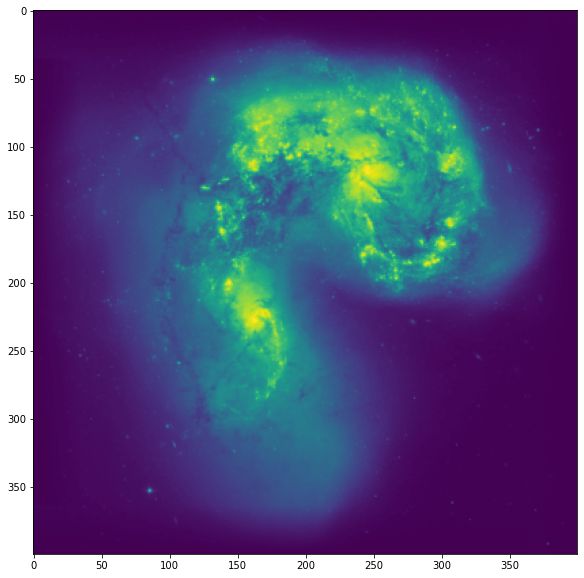

In [600]:
plt.figure(figsize = (10, 10))
plt.imshow(imgI)

In [601]:
import torch

In [602]:
import torch.nn as nn

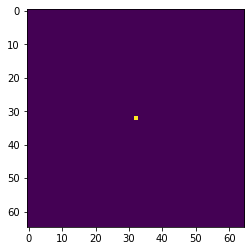

In [806]:
K = 65

kernel = np.zeros((K, K))
x = np.linspace(-64, 64, K)
X, Y = np.meshgrid(x, x)
R = (X**2 + Y**2)**0.5

for a, s in [[0.0, 30], [0, 50], [0.3, 5], [3.0, 0.5]]:
    kern = np.exp(-0.5*R**2/s**2)
    kern /= kern.sum()
    kernel += a*kern
    
plt.imshow(kernel)

In [807]:
kernel_gpu = torch.tensor(kernel).float()

In [808]:
gaussian_weights = nn.Parameter(kernel_gpu.unsqueeze(0).unsqueeze(0).cuda())
conv = FFTConv2d(in_channels = 1, out_channels = 1, kernel_size=K, bias=False, padding = int(K/2))
with torch.no_grad():
    conv.weight = gaussian_weights

In [809]:
def model(seeds):
    seeds = seeds * 20
    imgc = conv(seeds.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
    #imgc = seeds
    #imgc = torch.exp(imgc*0.5)
    #imgc = torch.nn.functional.softplus(imgc)
    imgc = torch.nn.functional.leaky_relu(imgc)
    return imgc

In [810]:
img0 = model(torch.randn(400, 400).cuda()).detach()

In [811]:
img0 = torch.tensor(imgI).float().cuda()*30

torch.Size([400, 400])

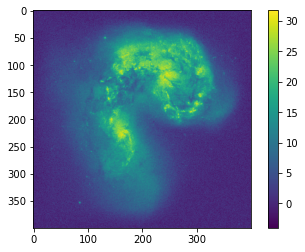

In [812]:
sigma= 1.0 * torch.ones_like(img0)
#sigma[150:] += 40
noise = torch.randn(img0.shape).cuda()*sigma
img0n = img0+noise
plt.imshow(img0n.detach().cpu())
plt.colorbar()
img0n.shape

In [813]:
seeds = torch.randn(400, 400).cuda()*0
G = torch.ones_like(seeds)
alpha = 0.99

In [814]:
for _ in range(1000):
    seeds.requires_grad = True
    img = model(seeds)
    sn = 0.5*((img - img0n)**2)/sigma**2
    CUT = 0
    sn -= 0.5*CUT**2
    loss = torch.maximum(sn, torch.zeros_like(sn)).sum()
    loss += (seeds**2).sum()*0.5
    loss.backward()
    epsilon = 1e-2
    
    G = alpha*G + (1-alpha)*seeds.grad**2
    M = 1/(G**0.5 + 1e-8)
    tau = epsilon*M
    eta = (tau*2)**0.5*0
    step = -tau*seeds.grad
    seeds = seeds.detach() + step + torch.randn(step.size()).cuda()*eta

0.19333194


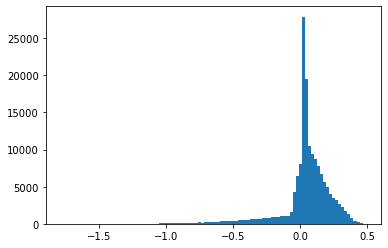

In [815]:
s = seeds.cpu().numpy().flatten()
print(s.std())
plt.hist(s, bins = 100);

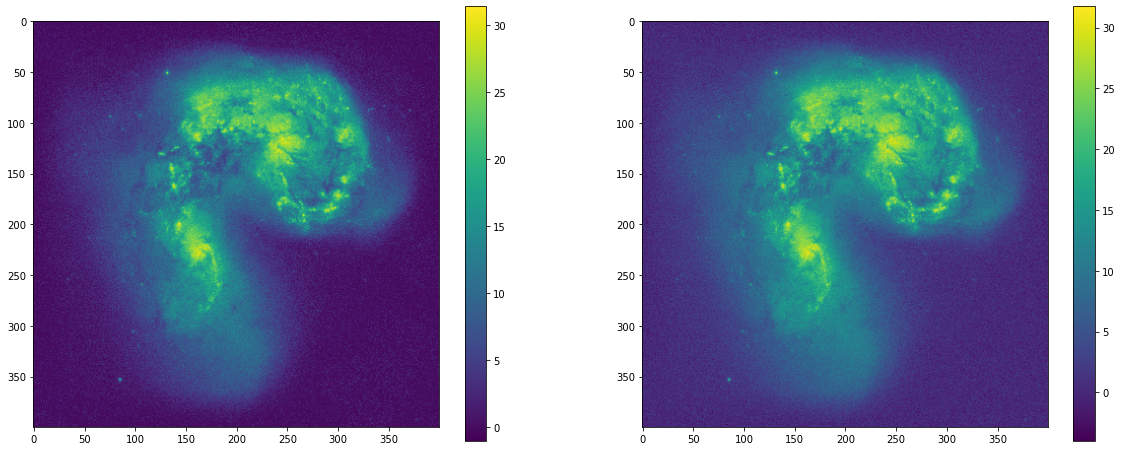

In [816]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
img = model(seeds)
plt.imshow(img.detach().cpu())
plt.colorbar()
plt.subplot(122)
plt.imshow(img0n.detach().cpu())
plt.colorbar()

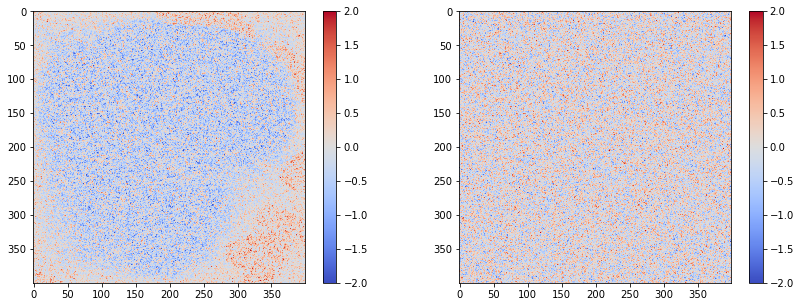

In [818]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.imshow(img.detach().cpu() - img0.detach().cpu(), vmin = -2, vmax = 2, cmap = 'coolwarm')
plt.colorbar()
plt.subplot(122)
plt.imshow(img0.detach().cpu() - img0n.detach().cpu(), vmin = -2, vmax = 2, cmap = 'coolwarm')
plt.colorbar()